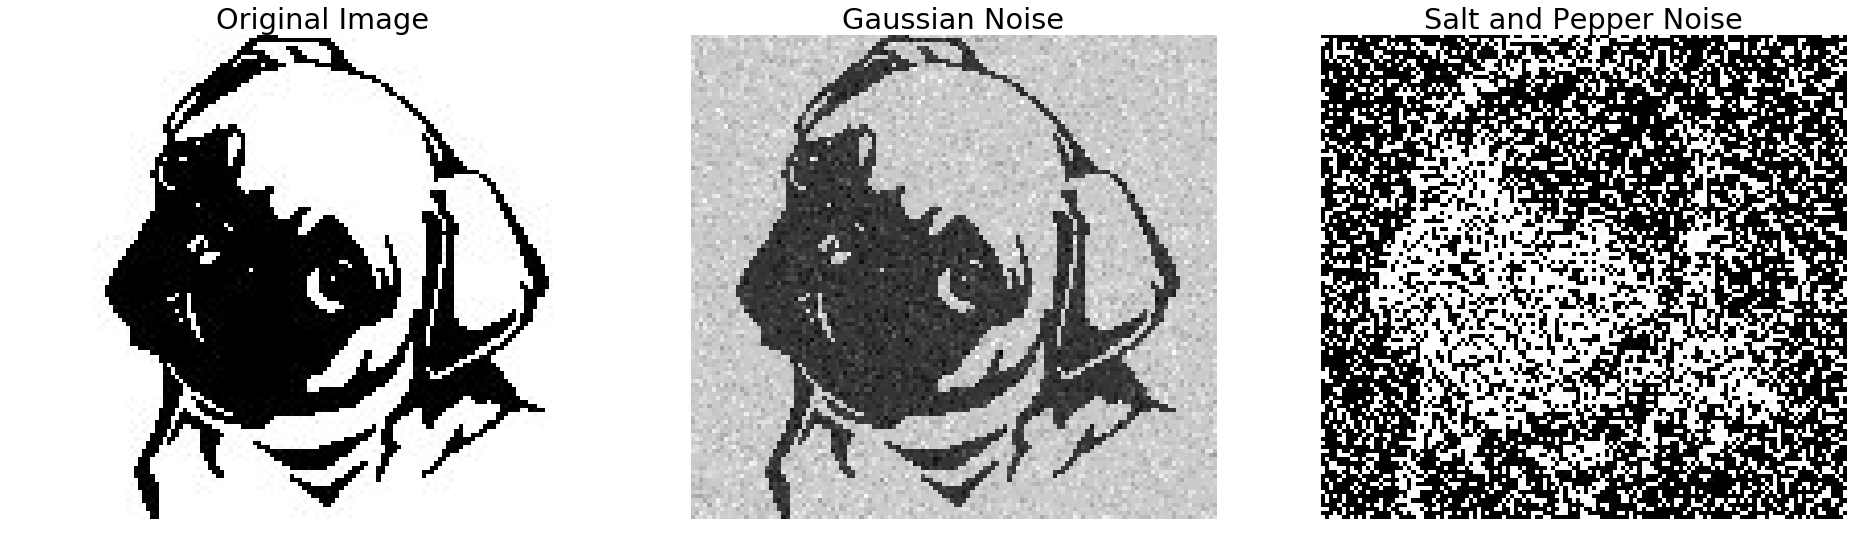

In [150]:
import numpy as np
import random
# np.set_printoptions(threshold=np.nan)
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.misc import imread
from scipy.ndimage import convolve, generate_binary_structure
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

def add_gaussian_noise(im, prop, varSigma):
    N = int(np.round(np.prod(im.shape) * prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N], im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] += e[index]
    return im2

def add_saltnpeppar_noise(im, prop):
    N = int(np.round(np.prod(im.shape) * prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N], im.shape)
    im2 = np.copy(im)
    im2[index] = 1 - im2[index]
    return im2

# proportion of pixels to alter
prop = 0.7
varSigma = 0.1
im = imread('image.jpg')
im = im / 255

fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_axis_off()
ax.set_title("Original Image")
ax.imshow(im, cmap='gray')

im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.set_axis_off()
ax2.set_title("Gaussian Noise")
ax2.imshow(im2, cmap='gray')

im3 = add_saltnpeppar_noise(im,prop)
ax3 = fig.add_subplot(133)
ax3.set_axis_off()
ax3.set_title("Salt and Pepper Noise")
ax3.imshow(im3,cmap='gray')

plt.show()

In [151]:
def neighbours(i, j, M, N, size = 4):
    if size == 4:
        if (i == 0 and j == 0):
            n = [(0,1), (1,0)]
        elif (i == 0 and j == N-1):
            n = [(0,N-2), (1,N-1)]
        elif (i == M-1 and j==0):
            n = [(M-1,1), (M-2,0)]
        elif (i == M-1 and j == N-1):
            n = [(M-1,N-2), (M-2,N-1)]
        elif (i == 0):
            n = [(0,j-1), (0,j+1), (1,j)]
        elif (i == M-1):
            n = [(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif (j == 0):
            n = [(i-1,0), (i+1,0), (i,1)]
        elif (j == N-1):
            n = [(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n = [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    if size == 8:
        if (i == 0 and j == 0):
            n = [(0,1), (1,0), (1,1)]
        elif (i == 0 and j == N-1):
            n = [(0,N-2), (1,N-1), (1,N-2)]
        elif (i == M-1 and j==0):
            n = [(M-1,1), (M-2,0), (M-2,1)]
        elif (i == M-1 and j == N-1):
            n = [(M-1,N-2), (M-2,N-1), (M-2, N-2)]
        elif (i == 0):
            n = [(0,j-1), (0,j+1), (1,j), (1,j-1), (1,j+1)]
        elif (i == M-1):
            n = [(M-1,j-1), (M-1,j+1), (M-2,j), (M-2,j-1), (M-2,j+1)]
        elif (j == 0):
            n = [(i-1,0), (i+1,0), (i,1), (i-1,1), (i+1,1)]
        elif (j == N-1):
            n = [(i-1,N-1), (i+1,N-1), (i,N-2), (i-1,N-2), (i+1,N-2)]
        else:
            n = [(i-1,j), (i+1,j), (i,j-1), (i,j+1), (i-1,j-1), (i+1,j-1), (i-1,j+1), (i+1,j+1)]
        return n
    
def neighbours_vec(A, size=4):
    if (size == 4):
        k = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    else:
        k = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    B = convolve(A, k, mode='constant') * A
    return B

In [152]:
def L_i(x, y):
    weight = 2.1
    return np.multiply(np.multiply(x, y), weight)

def E_0(i, j, x, x_i=None):
    weight = 1
    shape = x.shape
    neigh = neighbours(i, j, shape[0], shape[1], size=4)
    neigh = list(map((lambda t: x[t[0]][t[1]]), neigh))
    if x_i == None:
        return np.sum(1 * neigh * weight)
    else:
        neigh = np.reshape(neigh, (-1, 1))
        x_i = np.reshape(x_i, (-1, 1))
        return np.sum(weight * np.dot(x_i, neigh.T), axis=1)

def L(x, y):
    weight = -2.1
    return np.multiply(np.multiply(x, y), weight)

2


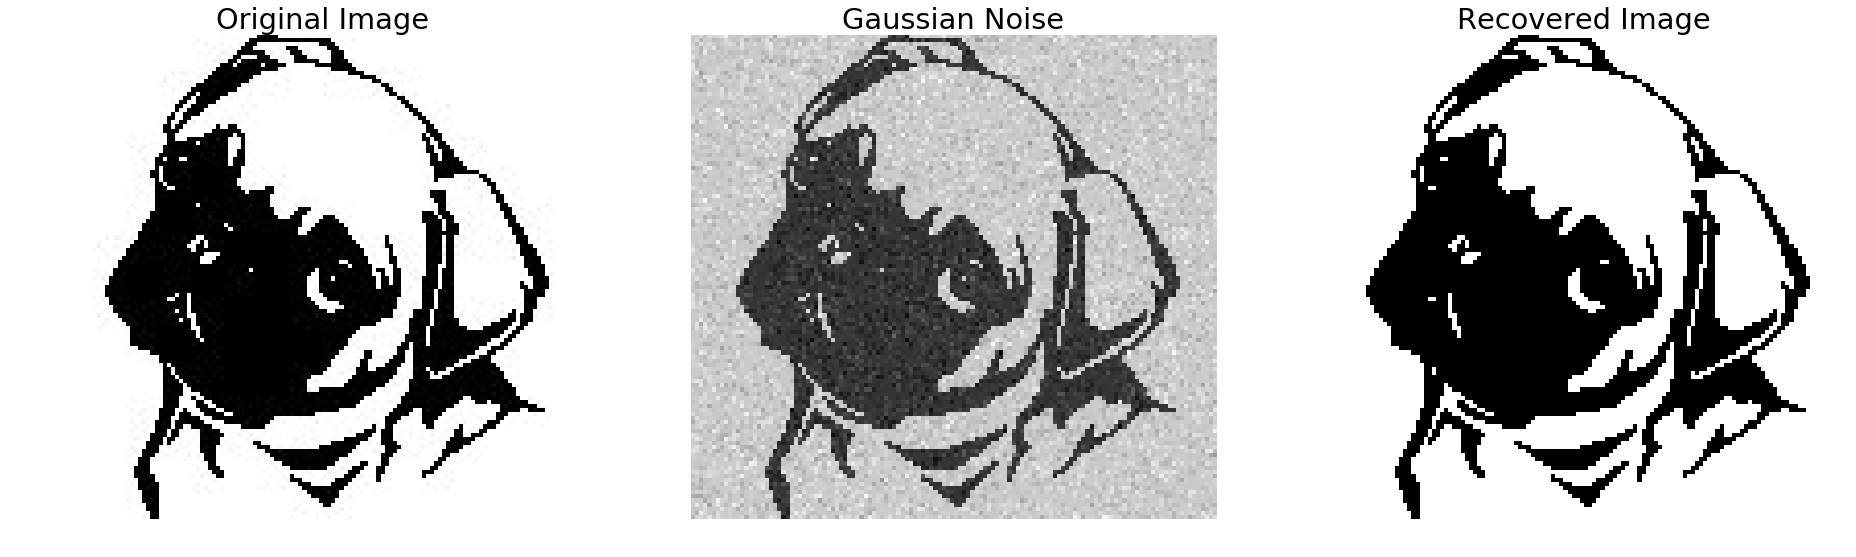

4


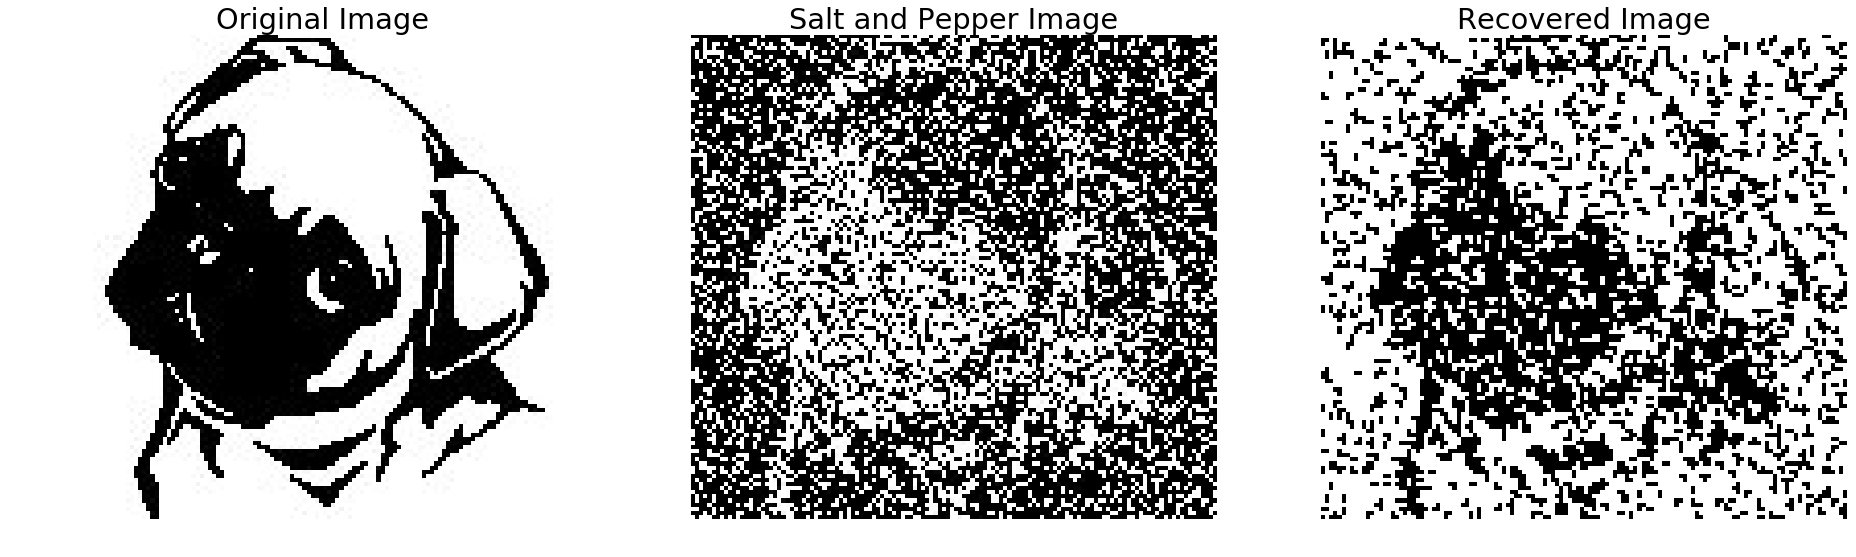

In [153]:
def compute_joint(i, j, x_i, x, y, L=None):
    if L == None:
        Z1 = np.sum(np.exp(L_i([-1, 1], y[i][j])))
        likelihood = np.divide(np.exp(L_i(x_i, y[i][j])), Z1)
    else:
        Z1 = np.sum(np.exp(L([-1, 1], y[i][j])))
        likelihood = np.divide(np.exp(L(x_i, y[i][j])), Z1)
    Z0 = np.sum(np.exp(E_0(i, j, x, x_i=[-1, 1])))
    prior = np.divide(np.exp(E_0(i, j, x, x_i)), Z0)[0]
    return (likelihood * prior)

def icm(img, iterations):
    img = img + (img - 1)
    shape = img.shape
    NUM_OF_ITER = iterations
    xPrev = np.copy(img)
    
    x = np.copy(img)
    for t in range(NUM_OF_ITER):
        for (i, j), x_i in np.ndenumerate(x):
            energy1 = compute_joint(i, j, 1, x, img)
            energy2 = compute_joint(i, j, -1, x, img)
            if energy1 > energy2:
                x[i][j] = 1
            else:
                x[i][j] = -1
        if (np.array_equal(x, xPrev)):
            print(t + 1)
            break;
        xPrev = np.copy(x)
    
    return (x + 1) / 2

x = icm((im2 > 0.5).astype(float), 20)

fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_axis_off()
ax.set_title("Original Image")
ax.imshow(im, cmap='gray')

ax2 = fig.add_subplot(132)
ax2.set_axis_off()
ax2.set_title("Gaussian Noise")
ax2.imshow(im2, cmap='gray')

ax3 = fig.add_subplot(133)
ax3.set_axis_off()
ax3.set_title("Recovered Image")
ax3.imshow(x, cmap='gray')

plt.show()

x2 = icm(im3, 20) * -1

fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_axis_off()
ax.set_title("Original Image")
ax.imshow(im, cmap='gray')

ax2 = fig.add_subplot(132)
ax2.set_axis_off()
ax2.set_title("Salt and Pepper Image")
ax2.imshow(im3, cmap='gray')

ax3 = fig.add_subplot(133)
ax3.set_axis_off()
ax3.set_title("Recovered Image")
ax3.imshow(x2, cmap='gray')

plt.show()

It takes 2 and 5 iterations respectively. For the salt and pepper image, this clearly still isn't a "decent" image, but for the gaussian, the image is very close to the original.

### Q2 ###

In [154]:
def compute_posterior(i, j, x, y, L=None):
    if L == None:
        Z1 = np.sum(np.exp(L_i([-1, 1], y[i][j])))
        likelihoodPos = np.divide(np.exp(L_i(1, y[i][j])), Z1)
        likelihoodNeg = np.divide(np.exp(L_i(-1, y[i][j])), Z1)
    else:
        Z1 = np.sum(np.exp(L([-1, 1], y[i][j])))
        likelihoodPos = np.divide(np.exp(L(1, y[i][j])), Z1)
        likelihoodNeg = np.divide(np.exp(L(-1, y[i][j])), Z1)
    Z0 = np.sum(np.exp(E_0(i, j, x, x_i=[-1, 1])))
    priorPos = np.divide(np.exp(E_0(i, j, x, x_i=1)), Z0)[0]
    priorNeg = np.divide(np.exp(E_0(i, j, x, x_i=-1)), Z0)[0]
    return (likelihoodPos * priorPos) / ((likelihoodPos * priorPos) + (likelihoodNeg * priorNeg))

def gibbs_sampling(img, iterations, L=None):
    img = img + (img - 1)
    NUM_OF_ITER = iterations
    xPrev = np.copy(img)
    
    x = np.copy(img)
    for _ in range(NUM_OF_ITER):
        for (i, j), x_i in np.ndenumerate(x):
            energy = compute_posterior(i, j, xPrev, img, L)
            t = np.random.uniform(0, 1)
            if energy > t:
                x[i][j] = 1
            else:
                x[i][j] = -1
        xPrev = np.copy(x)
    
    return (x + 1) / 2

def gibbs_random(img, iterations, L=None):
    img = img + (img - 1)
    NUM_OF_ITER = iterations
    print("Number of iterations: ", NUM_OF_ITER)
    xPrev = np.copy(img)
    
    x = np.copy(img)
    x_i = len(x)
    x_j = len(x[0])
    np.random.seed(42)
    for _ in range(NUM_OF_ITER):
        i = np.random.randint(0, x_i - 1)
        j = np.random.randint(0, x_j - 1)
        energy = compute_posterior(i, j, xPrev, img, L)
        t = np.random.uniform(0, 1)
        if energy > t:
            x[i][j] = 1
        else:
            x[i][j] = -1
        xPrev = np.copy(x)
    
    return (x + 1) / 2

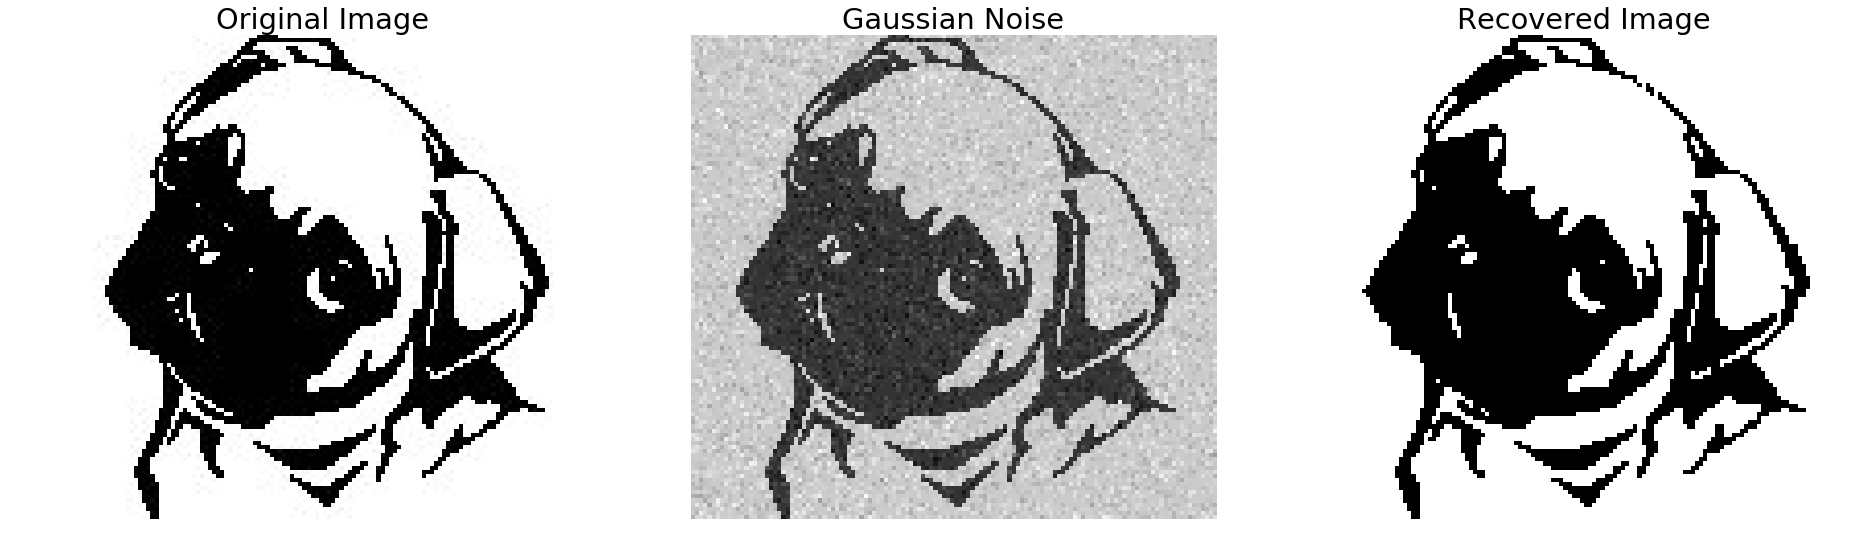

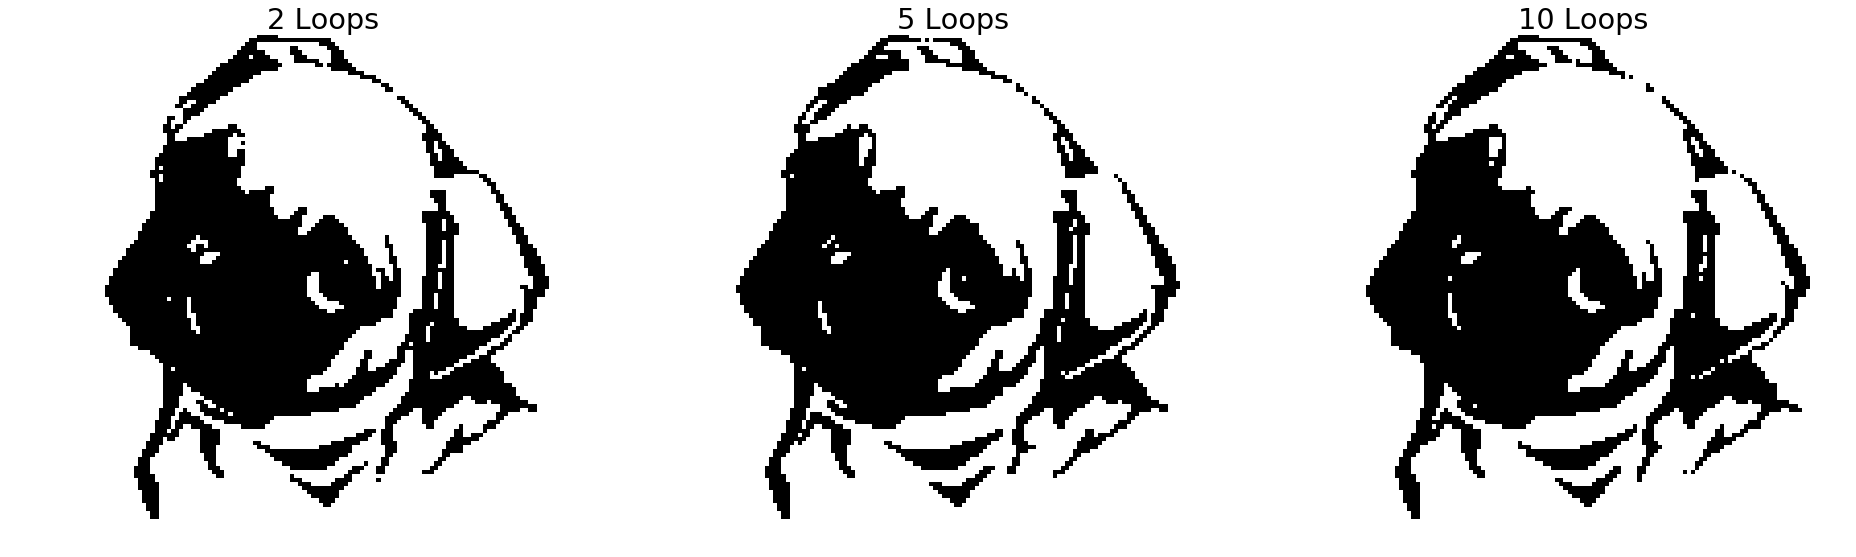

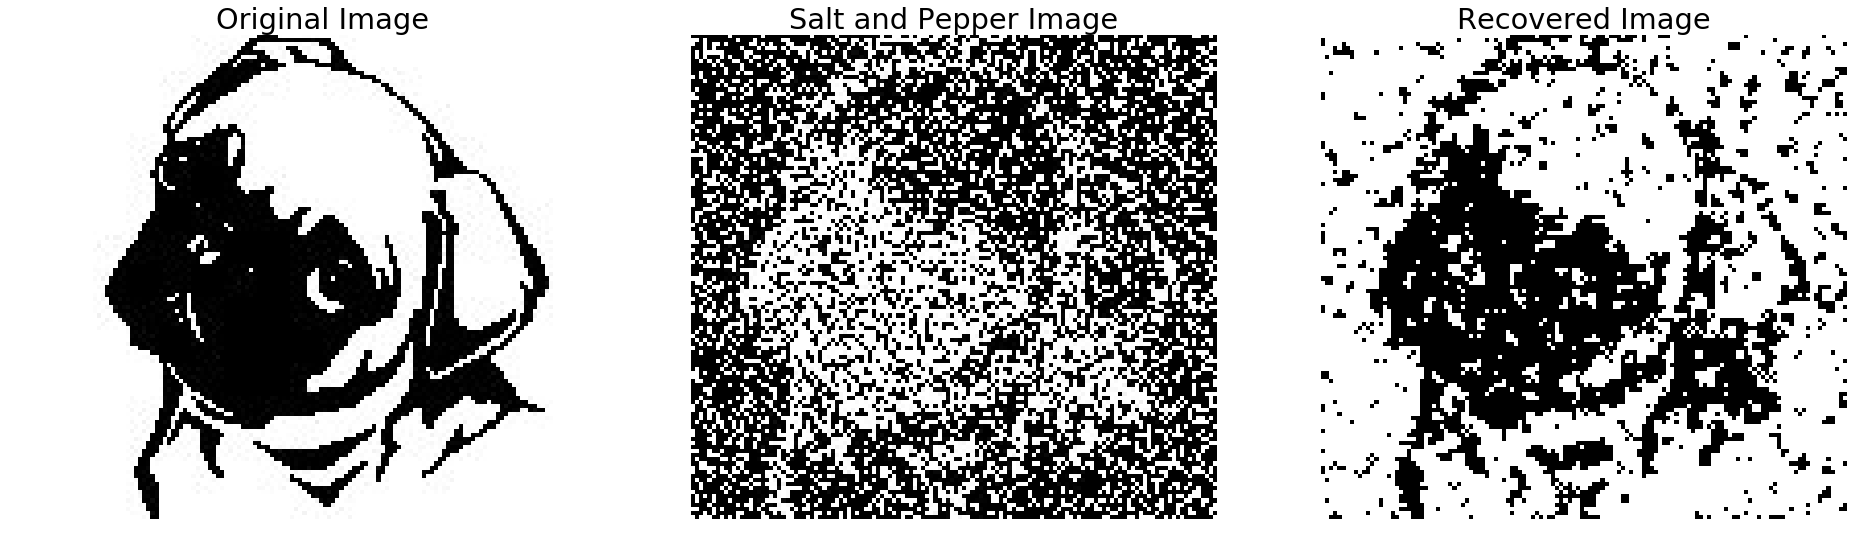

In [155]:
x = gibbs_sampling((im2 > 0.3).astype(float), 1)

fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_axis_off()
ax.set_title("Original Image")
ax.imshow(im, cmap='gray')

ax2 = fig.add_subplot(132)
ax2.set_axis_off()
ax2.set_title("Gaussian Noise")
ax2.imshow(im2, cmap='gray')

ax3 = fig.add_subplot(133)
ax3.set_axis_off()
ax3.set_title("Recovered Image")
ax3.imshow(x, cmap='gray')

plt.show()

x3_1 = gibbs_sampling((im2 > 0.3).astype(float), 2)
x3_2 = gibbs_sampling((im2 > 0.3).astype(float), 5)
x3_3 = gibbs_sampling((im2 > 0.3).astype(float), 10)

fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_axis_off()
ax.set_title("2 Loops")
ax.imshow(x3_1, cmap='gray')

ax2 = fig.add_subplot(132)
ax2.set_axis_off()
ax2.set_title("5 Loops")
ax2.imshow(x3_2, cmap='gray')

ax3 = fig.add_subplot(133)
ax3.set_axis_off()
ax3.set_title("10 Loops")
ax3.imshow(x3_3, cmap='gray')

plt.show()

x2 = gibbs_sampling(im3, 20, L)

fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_axis_off()
ax.set_title("Original Image")
ax.imshow(im, cmap='gray')

ax2 = fig.add_subplot(132)
ax2.set_axis_off()
ax2.set_title("Salt and Pepper Image")
ax2.imshow(im3, cmap='gray')

ax3 = fig.add_subplot(133)
ax3.set_axis_off()
ax3.set_title("Recovered Image")
ax3.imshow(x2, cmap='gray')

plt.show()

Number of iterations:  1


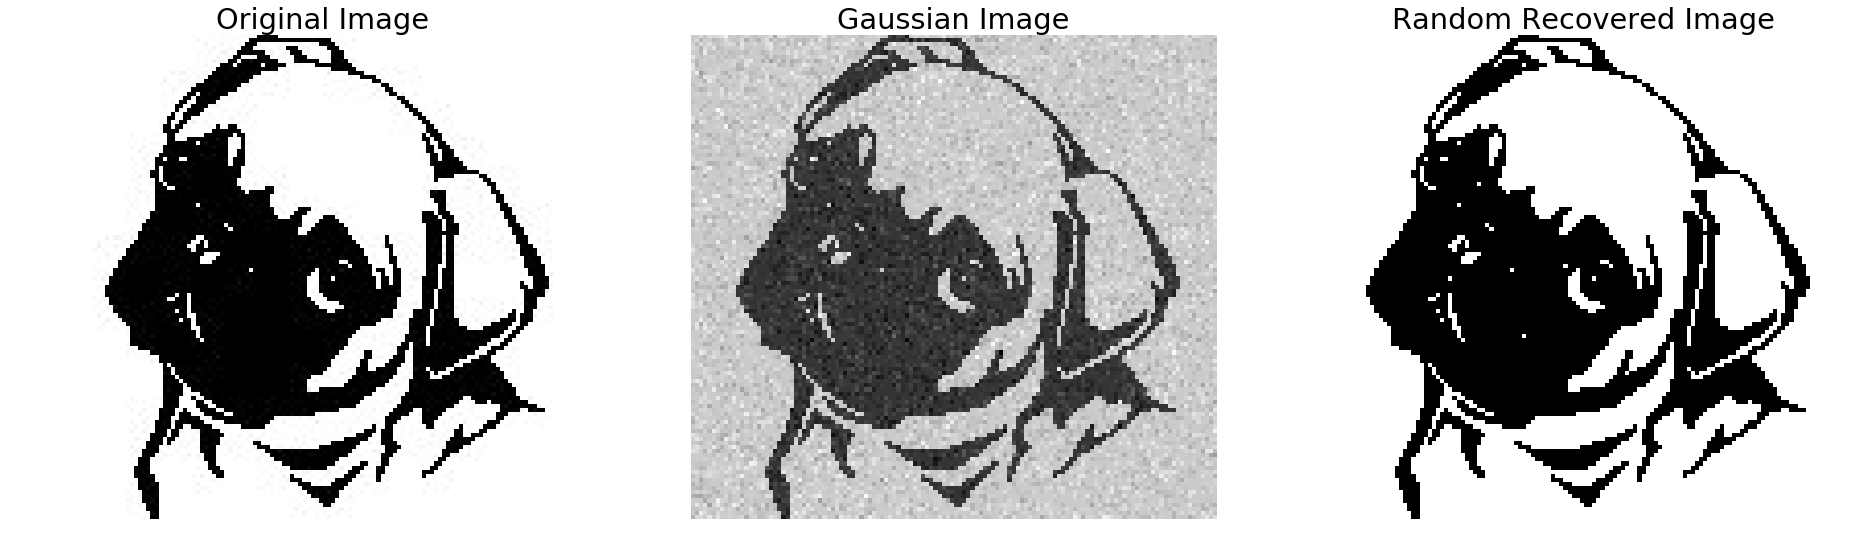

Number of iterations:  10
Number of iterations:  50
Number of iterations:  100


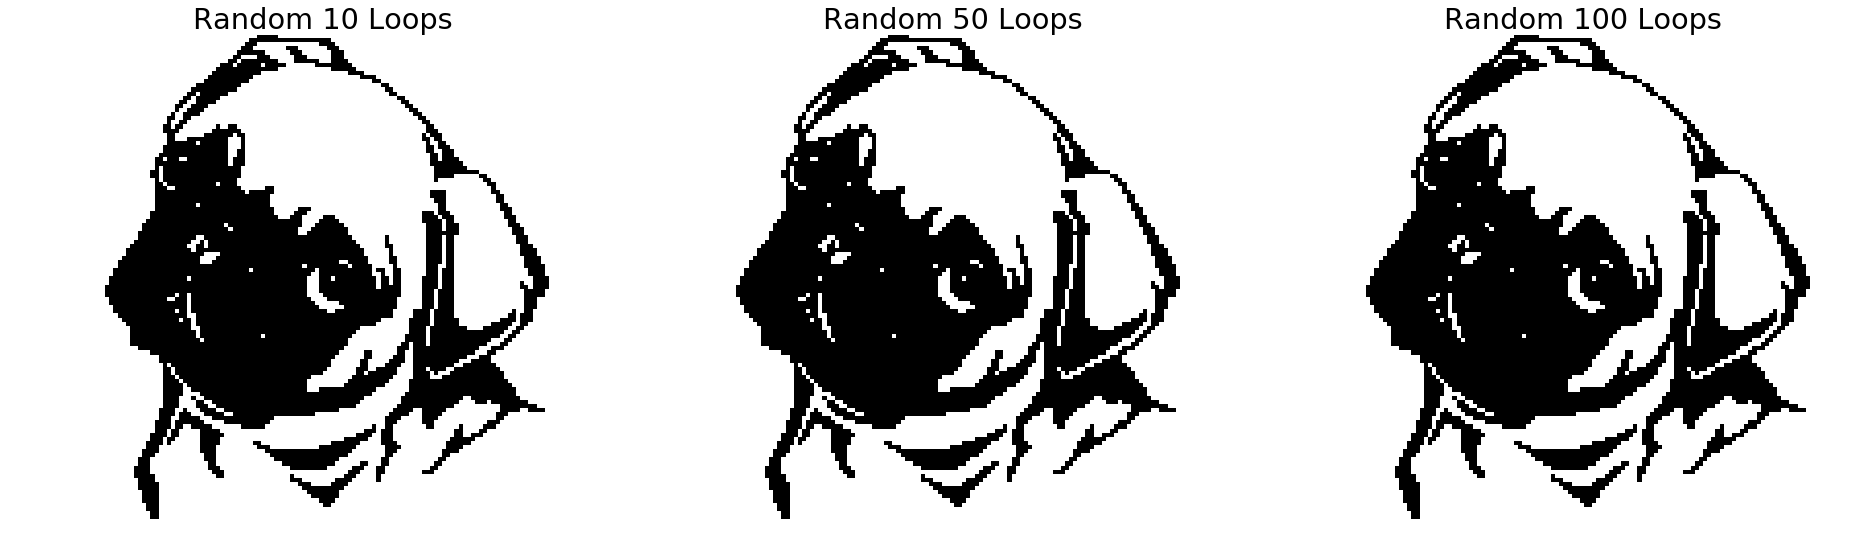

Number of iterations:  500000


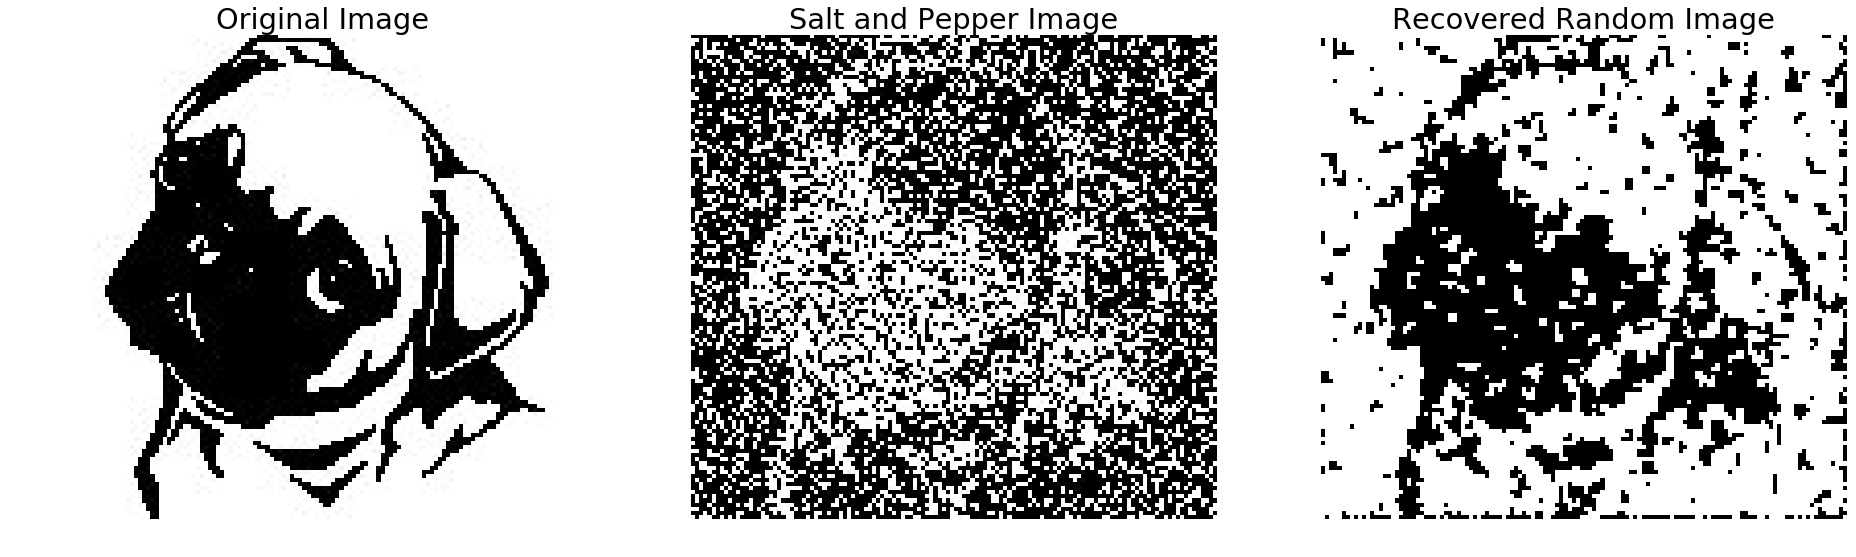

In [156]:
x3 = gibbs_random((im2 > 0.3).astype(float), 1)

fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_axis_off()
ax.set_title("Original Image")
ax.imshow(im, cmap='gray')

ax2 = fig.add_subplot(132)
ax2.set_axis_off()
ax2.set_title("Gaussian Image")
ax2.imshow(im2, cmap='gray')

ax3 = fig.add_subplot(133)
ax3.set_axis_off()
ax3.set_title("Random Recovered Image")
ax3.imshow(x3, cmap='gray')

plt.show()

x3_1 = gibbs_random((im2 > 0.3).astype(float), 10)
x3_2 = gibbs_random((im2 > 0.3).astype(float), 50)
x3_3 = gibbs_random((im2 > 0.3).astype(float), 100)

fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_axis_off()
ax.set_title("Random 10 Loops")
ax.imshow(x3_1, cmap='gray')

ax2 = fig.add_subplot(132)
ax2.set_axis_off()
ax2.set_title("Random 50 Loops")
ax2.imshow(x3_2, cmap='gray')

ax3 = fig.add_subplot(133)
ax3.set_axis_off()
ax3.set_title("Random 100 Loops")
ax3.imshow(x3_3, cmap='gray')

plt.show()

x4 = gibbs_random(im3, 500000, L)

fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_axis_off()
ax.set_title("Original Image")
ax.imshow(im, cmap='gray')

ax2 = fig.add_subplot(132)
ax2.set_axis_off()
ax2.set_title("Salt and Pepper Image")
ax2.imshow(im3, cmap='gray')

ax3 = fig.add_subplot(133)
ax3.set_axis_off()
ax3.set_title("Recovered Random Image")
ax3.imshow(x4, cmap='gray')

plt.show()

### 3 ###
When looping randomly, the gaussian noise image seems to near enough recover the image perfectly in what appears to be one iteration, whilst the S&P image seems to peak in quality at around the 500,000 iteration points. In this case, iterations are how many pixels are being updated.

### 4 ###
As stated above, the image does not always improve, particularly with the salt and pepper image, after an optimal number of iterations, the image declines back into a less-recognisable mess.
The gaussian example shows detrimental effects from looping more than a nice amount of times, as the image quality decreases the more loops are applied.

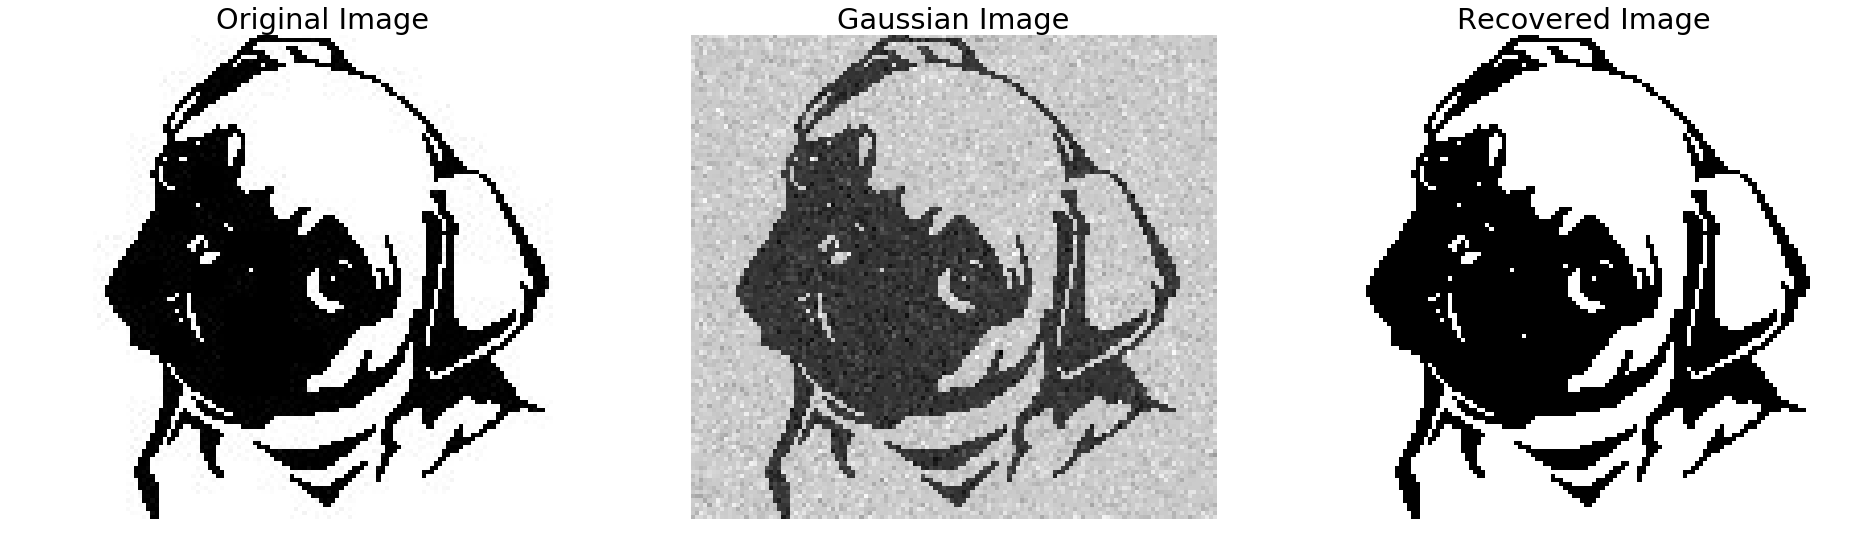

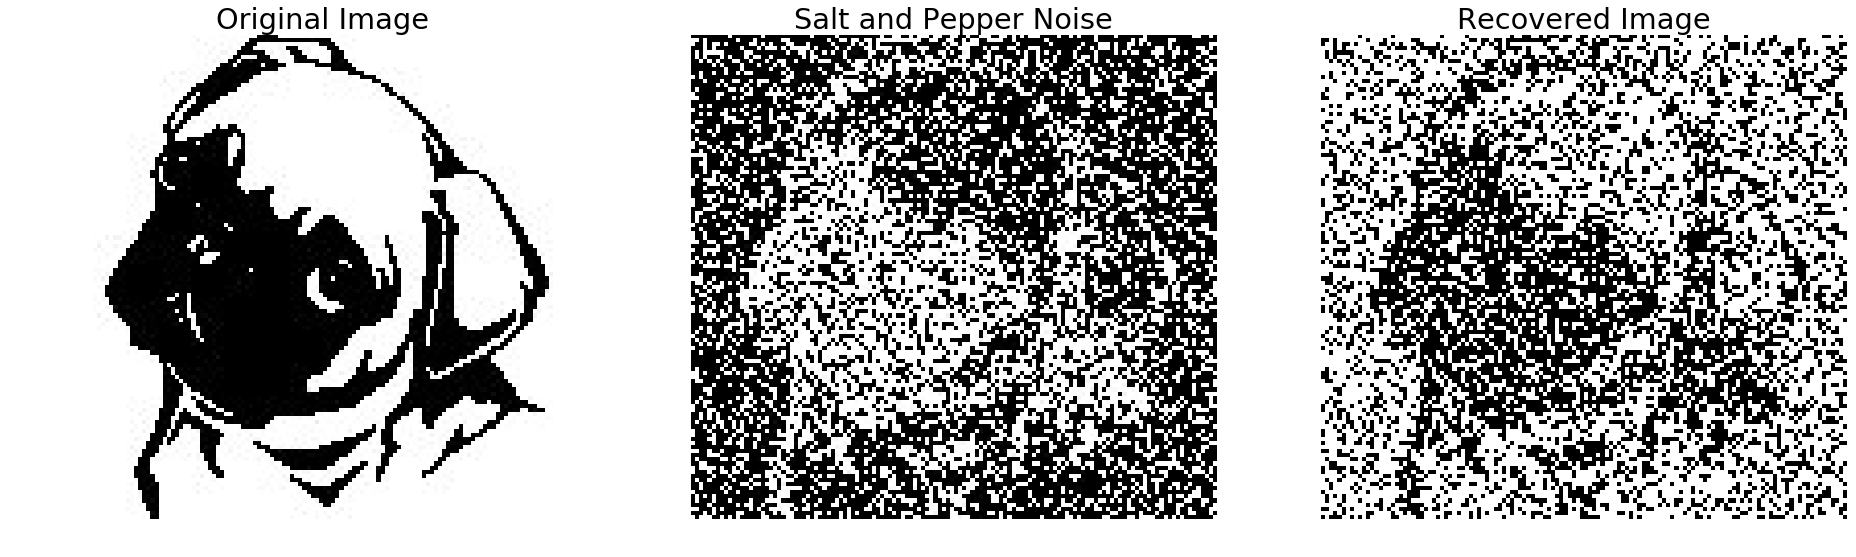

In [157]:
def mean_field(img, iterations, L=None):
    img = img + (img - 1)
    shape = np.shape(img)
    mu = np.copy(img)
    muPrev = np.copy(mu)
    m = np.random.randn(shape[0], shape[1])
    mPrev = np.copy(m)
    NUM_OF_ITER = iterations
    weight = 1
    if L == None:
        upd = L_i(1, img) - L_i(-1, img)
    else:
        upd = L(1, img) - L(-1, img)
    for _ in range(NUM_OF_ITER):
        for (i, j), _ in np.ndenumerate(mu):
            neigh = neighbours(i, j, shape[0], shape[1], size=4)
            neigh = [muPrev[t[0]][t[1]] for t in neigh]
            m[i, j] = np.sum(weight * neigh)
        mu = np.tanh(mPrev + upd)
        mPrev = np.copy(m)
        muPrev = np.copy(mu)
    return mu;

x = mean_field((im2 > 0.3).astype(float), 5) > 0

fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_axis_off()
ax.set_title("Original Image")
ax.imshow(im, cmap='gray')

ax2 = fig.add_subplot(132)
ax2.set_axis_off()
ax2.set_title("Gaussian Image")
ax2.imshow(im2, cmap='gray')

ax3 = fig.add_subplot(133)
ax3.set_axis_off()
ax3.set_title("Recovered Image")
ax3.imshow(x, cmap='gray')

plt.show()

x2 = mean_field(im3, 100, L) > 0

fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_axis_off()
ax.set_title("Original Image")
ax.imshow(im, cmap='gray')

ax2 = fig.add_subplot(132)
ax2.set_axis_off()
ax2.set_title("Salt and Pepper Noise")
ax2.imshow(im3, cmap='gray')

ax3 = fig.add_subplot(133)
ax3.set_axis_off()
ax3.set_title("Recovered Image")
ax3.imshow(x2, cmap='gray')

plt.show()

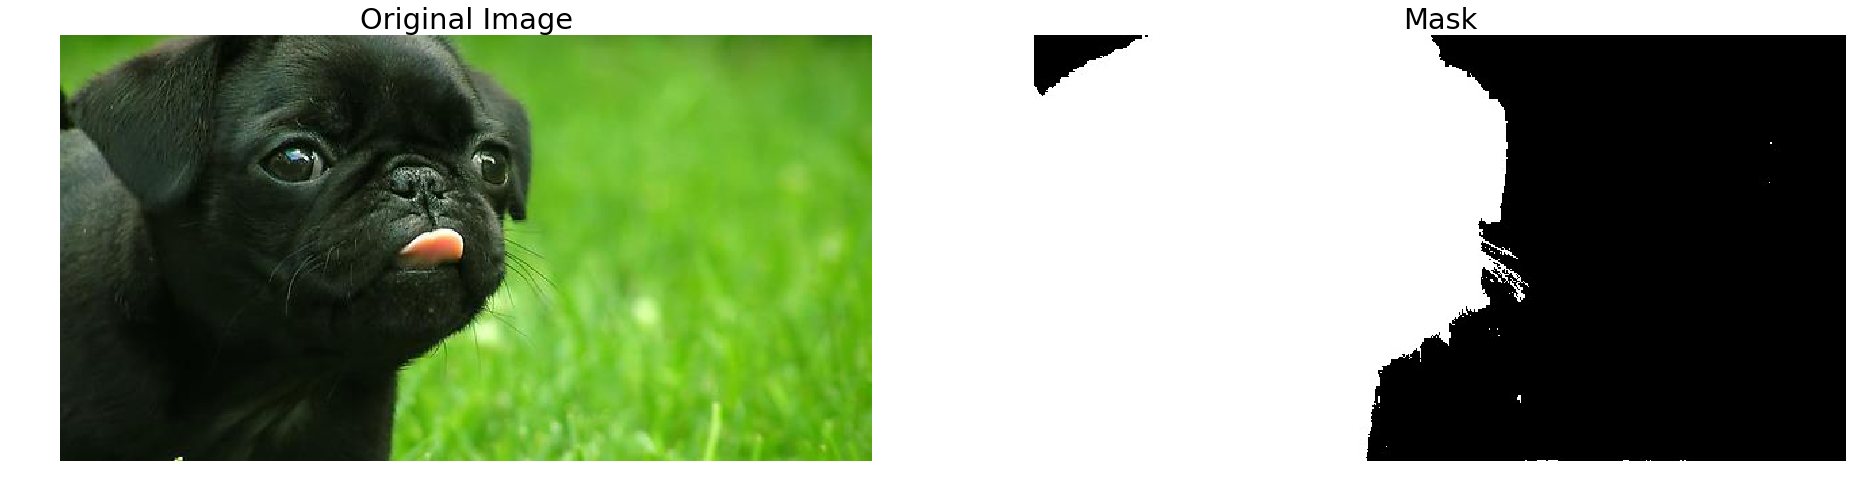

In [158]:
col = imread('colorImage.jpg')
mask = imread('colMask.jpg')
mask = mask / 255

fig = plt.figure()
ax = fig.add_subplot(121)
ax.set_axis_off()
ax.set_title("Original Image")
ax.imshow(col)

ax = fig.add_subplot(122)
ax.set_axis_off()
ax.set_title("Mask")
ax.imshow(mask, cmap='gray')

plt.show()

In [159]:
foregroundR = ax.hist(col[:, :, 0].flatten(), bins=256, weights=mask.flatten(), density=True)
backgroundR = ax.hist(col[:, :, 0].flatten(), bins=256, weights=((mask - 1) * -1).flatten(), density=True)
foregroundG = ax.hist(col[:, :, 1].flatten(), bins=256, weights=mask.flatten(), density=True)
backgroundG = ax.hist(col[:, :, 1].flatten(), bins=256, weights=((mask - 1) * -1).flatten(), density=True)
foregroundB = ax.hist(col[:, :, 2].flatten(), bins=256, weights=mask.flatten(), density=True)
backgroundB = ax.hist(col[:, :, 2].flatten(), bins=256, weights=((mask - 1) * -1).flatten(), density=True)

foregroundR = foregroundR[0]
backgroundR = backgroundR[0]
foregroundG = foregroundG[0]
backgroundG = backgroundG[0]
foregroundB = foregroundB[0]
backgroundB = backgroundB[0]

def seg_likelihood(img):
    weight = 20
    pos = foregroundR[img[:, :, 0]] + foregroundG[img[:, :, 1]] + foregroundB[img[:, :, 2]]
    neg = backgroundR[img[:, :, 0]] + backgroundG[img[:, :, 1]] + backgroundB[img[:, :, 2]]
    return weight * (pos - neg)

def mean_field_segmentation(img, iterations):
    shape = np.shape(img)
    mu = ((np.dot(img, [0.299, 0.587, 0.114]) / 255) < 0.5).astype(float)
    muPrev = np.copy(mu)
    m = np.random.randn(shape[0], shape[1])
    mPrev = np.copy(m)
    NUM_OF_ITER = iterations
    weight = 1.5
    likelihood = seg_likelihood(img)
    for _ in range(NUM_OF_ITER):
        for (i, j), _ in np.ndenumerate(mu):
            neigh = neighbours(i, j, shape[0], shape[1], size=4)
            neigh = np.array([muPrev[t[0]][t[1]] for t in neigh], dtype=np.float32)
            m[i, j] = np.sum(weight * neigh)
        mu = np.tanh(mPrev + likelihood)
        mPrev = np.copy(m)
        muPrev = np.copy(mu)
    return mu;

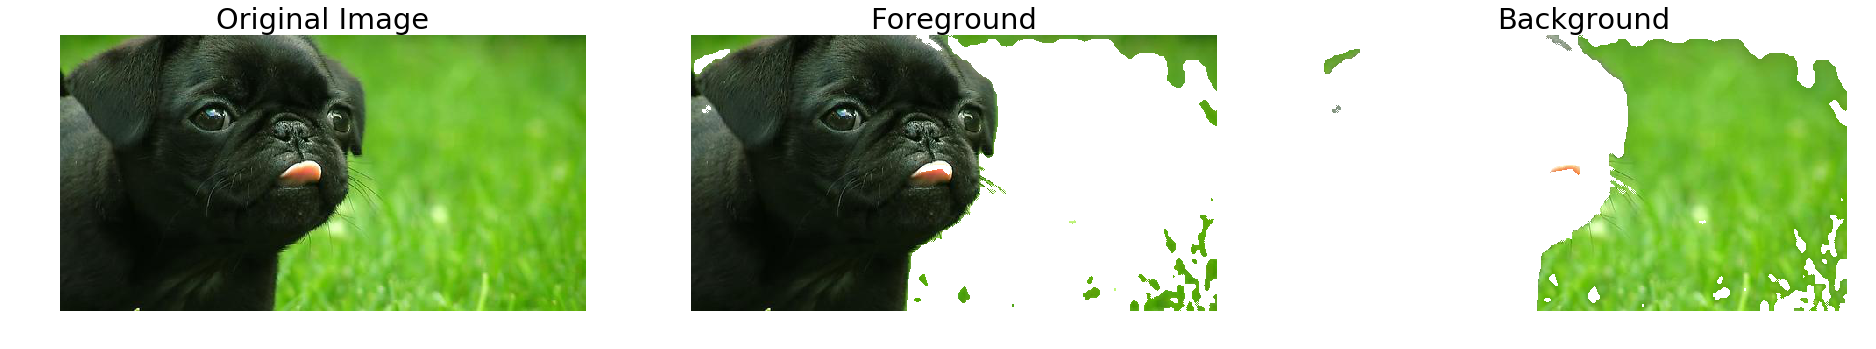

In [160]:
x = mean_field_segmentation(col, 20) > 0.1

fig = plt.figure()
ax = fig.add_subplot(131)
ax.set_axis_off()
ax.set_title("Original Image")
ax.imshow(col)

newX = np.repeat(x[:, :, np.newaxis], 3, axis=2)

ax2 = fig.add_subplot(132)
ax2.set_axis_off()
ax2.set_title("Foreground")
ax2.imshow(np.where(newX, col, 255))

ax2 = fig.add_subplot(133)
ax2.set_axis_off()
ax2.set_title("Background")
ax2.imshow(np.where(newX == False, col, 255))

plt.show()